# Preparation

In [1]:
import numpy as np
from xml.etree import ElementTree
import cv2
from PIL import Image
import tensorflow as tf
import csv
import argparse
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
save_path = '/home/ubuntu/Sayama/tmpdir/2020_08_04/video1top_png/image_02/data/'


In [3]:
file_names=["frame_000250.png"]

#If you want to try all files, please execute below:
#for file in os.listdir(save_path):
    # Getting File Names
    #if os.path.isfile(os.path.join(save_path, file)):
        #file_names.append(os.path.basename(file))

In [4]:
file_names_2 = ["frame_000250"]

#If you want to try all files, please execute below:
#for file in os.listdir(save_path):
    #if os.path.isfile(os.path.join(save_path, file)):
        #file2 = file.rstrip('.png\n')
        #file_names_2.append(file2)

# Check File Content

In [5]:
def draw_images(image_file):
    
    global save_path
    
    f_name=save_path+"/"+image_file
    gray_img=cv2.imread(f_name)
   

    
    
    return gray_img



frame_000250.png


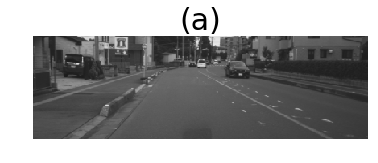

In [6]:
#Showing img
for number, image in enumerate(file_names[0:1]):
    print(image)
    gray_img = draw_images(image)
    plt.title("(a)", fontsize=30)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))


# Before fine tuning

In [7]:
depth_map_dir="/home/ubuntu/Sayama/result_video1top_273486/"
i=0
pred_depth=np.load(depth_map_dir+file_names_2[i] +'.npy')

In [8]:
pred_depth = cv2.resize(pred_depth, (416,128))

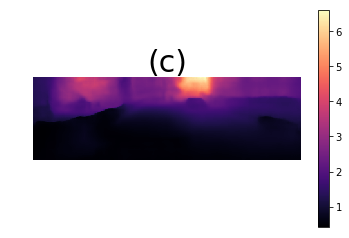

In [9]:
plt.imshow(pred_depth, cmap='magma')
plt.title("(c)", fontsize=30)
plt.axis('off')
plt.colorbar()

# After fine tuning

In [10]:
depth_map_dir="/home/ubuntu/Sayama/result_video1top_279296/"
i=0
pred_depth=np.load(depth_map_dir+file_names_2[i] +'.npy')

In [11]:
pred_depth = cv2.resize(pred_depth, (416,128))

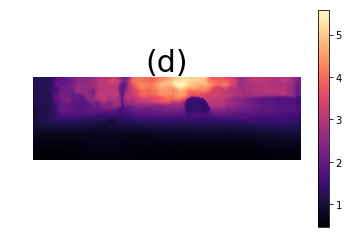

In [12]:
plt.imshow(pred_depth, cmap='magma')
plt.title("(d)", fontsize=30)
plt.axis('off')
plt.colorbar()

# Parameters for Abs Rel Error Calculation

In [13]:
min_depth=5
max_depth=80
bf=109.65
d_inf=2.67

# Calculation of Abs Rel Error

In [14]:
# Answer Disparity Map Directory
ans_int_disp_map_dir="/home/ubuntu/Sayama/tmpdir/2020_08_04/video1middle_png/image_02/data"

In [15]:
def draw_images_ans_int(image_file):
    
    global ans_int_disp_map_dir
    
    f_name=ans_int_disp_map_dir+"/"+image_file
    ans_int_disp_map=cv2.imread(f_name)
    ans_int_disp_map=cv2.cvtColor(ans_int_disp_map, cv2.COLOR_RGB2GRAY)
   

    
    
    return ans_int_disp_map



frame_000250.png


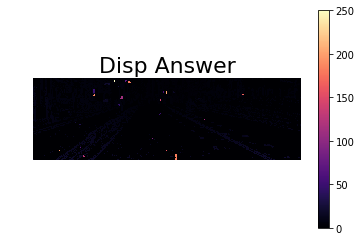

In [16]:
for number, image in enumerate(file_names[0:1]):
    print(image)
    ans_int_disp_map = draw_images_ans_int(image)
    #plt.figure(dpi=50)
    plt.imshow(ans_int_disp_map, cmap='magma')
    plt.title("Disp Answer", fontsize=22)
    plt.axis('off')
    plt.colorbar()

In [17]:
gt_depth=bf/(ans_int_disp_map-d_inf)

In [18]:
mask = np.logical_and(gt_depth>min_depth,gt_depth <max_depth)

In [19]:
gt_depth=gt_depth*mask

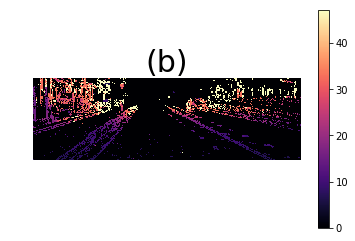

In [20]:
plt.imshow(gt_depth, cmap='magma')
plt.title("(b)", fontsize=30)
plt.axis('off')
plt.colorbar()

In [21]:
scalor = np.median(gt_depth[mask])/np.median(pred_depth[mask])

In [22]:
print(scalor)

15.557166958477538


In [23]:
pred_depth[mask] *= scalor

In [24]:
pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth

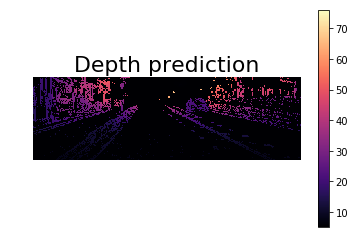

In [25]:
plt.imshow(pred_depth, cmap='magma')
plt.title("Depth prediction", fontsize=22)
plt.axis('off')
plt.colorbar()

In [26]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    
    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [27]:
num_test=1
i=0

In [28]:
rms     = np.zeros(num_test, np.float32)
log_rms = np.zeros(num_test, np.float32)
abs_rel = np.zeros(num_test, np.float32)
sq_rel  = np.zeros(num_test, np.float32)
d1_all  = np.zeros(num_test, np.float32)
a1      = np.zeros(num_test, np.float32)
a2      = np.zeros(num_test, np.float32)
a3      = np.zeros(num_test, np.float32)
scalors = np.zeros(num_test, np.float32)

In [29]:
abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = \
            compute_errors(gt_depth[mask], pred_depth[mask])

print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} ".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3', 'scalor'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f} ,{:10.4f} ".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean(),scalors.mean()))


   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3,     scalor 
    0.2200,     3.2736,     8.1894,     0.2997,     0.0000,     0.7191,     0.9162,     0.9663 ,    0.0000 


# Scale Matching with acceleration value

In [30]:
depth_map_dir="/home/ubuntu/Sayama/result_video1top_279296/"
i=0
pred_depth=np.load(depth_map_dir+file_names_2[i] +'.npy')

In [31]:
pred_depth = cv2.resize(pred_depth, (416,128))

In [32]:
for number, image in enumerate(file_names[0:1]):
    print(image)
    ans_int_disp_map = draw_images_ans_int(image)

frame_000250.png


In [33]:
gt_depth=bf/(ans_int_disp_map-d_inf)

In [34]:
mask = np.logical_and(gt_depth>min_depth,gt_depth <max_depth)

In [35]:
gt_depth=gt_depth*mask

In [36]:
import math

In [37]:
def calc_center(xmin=0,ymin=0,img_height=128,img_width=416,clip_height=128,clip_width=416,dfv_height=128,dfv_width=416):
    center_ratio_x=(img_height//2-xmin)/clip_height
    center_ratio_y=(img_width//2-ymin)/clip_width
    center_x=int(dfv_height*center_ratio_x)
    center_y=int(dfv_width*center_ratio_y)
    return [center_x,center_y]

In [38]:
height=1.2
acceleration=0.065
theta=math.asin(acceleration)
truth_z=height/math.sin(theta)
print(truth_z)

18.46153846153846


In [39]:
center=calc_center()
present_z=pred_depth[center[0]][center[1]]
print(present_z)

1.5661092


In [40]:
scalor=truth_z/present_z
print(scalor)

11.788155444072302


In [41]:
pred_depth[mask] *= scalor

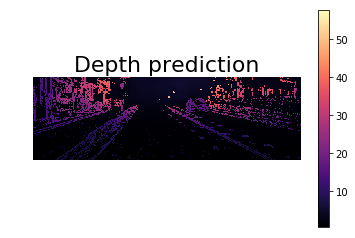

In [42]:
plt.imshow(pred_depth, cmap='magma')
plt.title("Depth prediction", fontsize=22)
plt.axis('off')
plt.colorbar()

In [43]:
pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth

In [44]:
abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])

In [45]:
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} ".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3', 'scalor'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f} ,{:10.4f} ".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean(),scalors.mean()))



   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3,     scalor 
    0.2713,     3.8167,    11.0256,     0.4067,     0.0000,     0.4689,     0.7936,     0.8965 ,    0.0000 


# No Scale Matching

In [46]:
depth_map_dir="/home/ubuntu/Sayama/result_video1top_279296/"
i=0
pred_depth=np.load(depth_map_dir+file_names_2[i] +'.npy')

In [47]:
pred_depth = cv2.resize(pred_depth, (416,128))

In [48]:
for number, image in enumerate(file_names[0:1]):
    print(image)
    ans_int_disp_map = draw_images_ans_int(image)

frame_000250.png


In [49]:
gt_depth=bf/(ans_int_disp_map-d_inf)

In [50]:
mask = np.logical_and(gt_depth>min_depth,gt_depth <max_depth)

In [51]:
gt_depth=gt_depth*mask

In [52]:
scalor=1
print(scalor)

1


In [53]:
pred_depth[mask] *= scalor

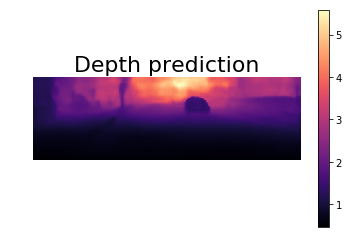

In [54]:
plt.imshow(pred_depth, cmap='magma')
plt.title("Depth prediction", fontsize=22)
plt.axis('off')
plt.colorbar()

In [55]:
pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth

In [56]:
abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])

In [57]:
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} ".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3', 'scalor'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f} ,{:10.4f} ".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean(),scalors.mean()))




   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3,     scalor 
    0.7377,    18.6075,    26.2039,     1.6522,     0.0000,     0.0023,     0.0636,     0.1569 ,    0.0000 
